# TEXT CLASSIFICATION

At first, let's import the dataset from my directory. I have also set maximum column width in order to read the transcription. If not set, the transcrip will only show partially due to there are many words for each transcription record.

In [1]:
import os
path ='C:/Users/Lee Kah Win/Desktop/Master DS Subjects/SEM2/cds522/project'
os.chdir(path)
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 255)
df =pd.read_csv('mtsamples_three_classes.csv')
df.head(3)

,description,medical_specialty,sample_name,transcription,keywords
0,"A complex closure and debridement of wound. The patient is a 26-year-old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant, just below the costal margin that was lanced by General Surg...",Neurosurgery,Wound Closure & Debridement - Hydrocephalus,"TITLE OF OPERATION:, A complex closure and debridement of wound.,INDICATION FOR SURGERY:, The patient is a 26-year-old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant, just below the...","neurosurgery, debridement of wound, shunt, costal margin, cerebrospinal fluid, cerebrospinal, closure, debridement, hydrocephalus, surgery, draining, fistula, wound,"
1,Placement of right new ventriculoperitoneal (VP) shunts Strata valve and to removal of right frontal Ommaya reservoir.,Neurosurgery,VP Shunt Placement,"TITLE OF OPERATION: , Placement of right new ventriculoperitoneal (VP) shunts Strata valve and to removal of right frontal Ommaya reservoir.,INDICATION FOR SURGERY: , The patient is a 2-month-old infant, born premature with intraventricular hemorrhage...","neurosurgery, ommaya reservoir, frontal, strata valve, intraventricular hemorrhage, vp shunt, ventriculoperitoneal, hydrocephalus,"
2,Endoscopic third ventriculostomy.,Neurosurgery,Ventriculostomy,"PREOPERATIVE DIAGNOSIS: , Aqueductal stenosis.,POSTOPERATIVE DIAGNOSIS:, Aqueductal stenosis.,TITLE OF PROCEDURE: ,Endoscopic third ventriculostomy.,ANESTHESIA: , General endotracheal tube anesthesia.,DEVICES:, Bactiseal ventricular catheter with a...","neurosurgery, aqueductal stenosis, ventriculostomy, triventricular hydrocephalus, neuropen, endoscopic third ventriculostomy, endotracheal tube anesthesia, burr hole port, aqueductal,"


To query the data, I would like to know how is the size of the dataset and also to rank null values in descending order

In [2]:
total_word_count = df['transcription'].str.split().str.len().sum()
df_ent =df.loc[(df['medical_specialty'] == ' ENT - Otolaryngology')]
df_dc =df.loc[(df['medical_specialty'] == ' Discharge Summary')]
df_neu =df.loc[(df['medical_specialty'] == ' Neurosurgery')]
total_word_count_ent = df_ent['transcription'].str.split().str.len().sum()
total_word_count_dc = df_dc['transcription'].str.split().str.len().sum()
total_word_count_dc = df_dc['transcription'].str.split().str.len().sum()
total_word_count_neu = df_neu['transcription'].str.split().str.len().sum()

In [3]:
print(f'The word count of all transcription is: {int(total_word_count)}')
print(f'The word count of ENT - Otolaryngology transcription is: {int(total_word_count_ent)}')
print(f'The word count of Discharge Summary transcription is: {int(total_word_count_dc)}')
print(f'The word count of Neurosurgery transcription is: {int(total_word_count_neu)}')

The word count of all transcription is: 139368
The word count of ENT - Otolaryngology transcription is: 42032
The word count of Discharge Summary transcription is: 43103
The word count of Neurosurgery transcription is: 54233


In [4]:
# to print data shape
print(f'data shape is: {df.shape}')

# to identify the null values by descending order
df.isnull().sum().sort_values(ascending = False)

data shape is: (300, 5)


keywords             56
transcription         2
description           0
medical_specialty     0
sample_name           0
dtype: int64

One important detail is that I found out there are 2 rows containing no transcription. They should be removed as transcription is our only predictors in this text classification task.

In [5]:
# to remove transcription rows that is empty
df = df[df['transcription'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 299
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        298 non-null    object
 1   medical_specialty  298 non-null    object
 2   sample_name        298 non-null    object
 3   transcription      298 non-null    object
 4   keywords           242 non-null    object
dtypes: object(5)
memory usage: 14.0+ KB


After dropping the null values, there are no null values for the transcription attribute. Now it has decreased slightly to 4966 observations in this dataset.

Moreover, the aim of this project is to use the text transcription to predict the topic labels. Hence, other redundant columns namely 'description', 'sample_name' and 'keywords' should be removed.

In [6]:
# drop redundant columns
df =df.drop(['description','sample_name','keywords'], axis=1)
df.head(2)

,medical_specialty,transcription
0,Neurosurgery,"TITLE OF OPERATION:, A complex closure and debridement of wound.,INDICATION FOR SURGERY:, The patient is a 26-year-old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant, just below the..."
1,Neurosurgery,"TITLE OF OPERATION: , Placement of right new ventriculoperitoneal (VP) shunts Strata valve and to removal of right frontal Ommaya reservoir.,INDICATION FOR SURGERY: , The patient is a 2-month-old infant, born premature with intraventricular hemorrhage..."


The target labels (or the topic) is the 'medical_specialty' attribute. Now, let's identify how is the value counts of the target labels, and as well visualise it in a bar chart. In order to visualise in matplotlib, function of flattening list is defined in order to put the target value counts into the matplotlib function.

In [7]:
# function to flatten one list
def flat_list(unflat_list):
    flatted = [item for sublist in unflat_list for item in sublist]
    return flatted

In [8]:
# to convert value counts into list format
value_counts =df[['medical_specialty']].value_counts().rename_axis('medical_specialty').reset_index(name='value_counts')
labels = flat_list(value_counts[['medical_specialty']].values.tolist())
value_counts = flat_list(value_counts[['value_counts']].values.tolist())

In [9]:
# To count how many labels in the dataset`
print(f"There are {len(labels)} target labels")

There are 3 target labels


<BarContainer object of 3 artists>

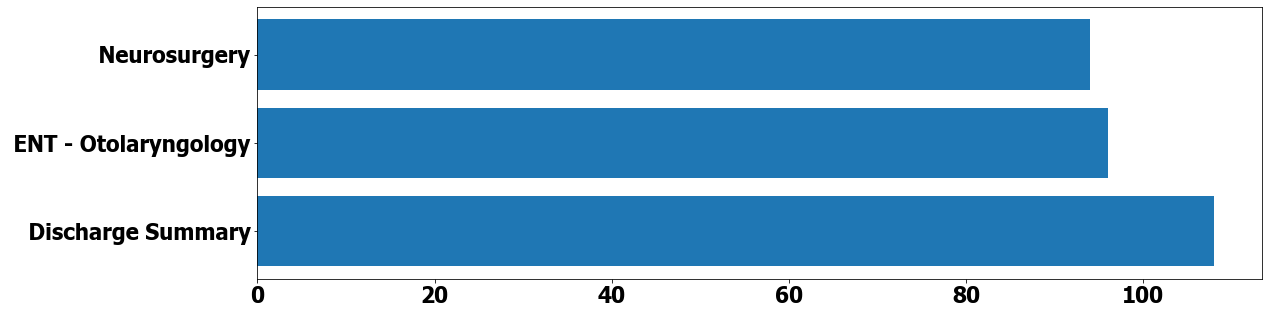

In [10]:
import matplotlib
font = {'family' : 'Tahoma',
        'weight' : 'bold',
        'size'   : 22}
import matplotlib.pyplot as plt
matplotlib.rc('font', **font)
def bar_plot(labels, value_counts):
    f, ax = plt.subplots(figsize=(18,5))
    return plt.barh(labels, value_counts)

bar_plot(labels, value_counts)

The target labels is quite balanced

# Data Normalisation

Data normalisation will be conducted for the trascription. One of the reasons is to convert the transcript into standard format, which important for data extraction later. In this data normalisation task, following task will be executed, which are:
1. Lowe Case
2. Removing punctuation and numbers
3. Tokenisation of the transcription
4. Lemmatisation
5. Remove Stop Words

Step 1: Lower Case

In [11]:
# To convert transcription into lowercase
def lower(df, attribute):
    df.loc[:,attribute] = df[attribute].apply(lambda x : str.lower(x))
    return df
df = lower(df,'transcription')
df.head(3)

,medical_specialty,transcription
0,Neurosurgery,"title of operation:, a complex closure and debridement of wound.,indication for surgery:, the patient is a 26-year-old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant, just below the..."
1,Neurosurgery,"title of operation: , placement of right new ventriculoperitoneal (vp) shunts strata valve and to removal of right frontal ommaya reservoir.,indication for surgery: , the patient is a 2-month-old infant, born premature with intraventricular hemorrhage..."
2,Neurosurgery,"preoperative diagnosis: , aqueductal stenosis.,postoperative diagnosis:, aqueductal stenosis.,title of procedure: ,endoscopic third ventriculostomy.,anesthesia: , general endotracheal tube anesthesia.,devices:, bactiseal ventricular catheter with a..."


Step 2: Remove Punctuation and Numbers

In [12]:
# To remove transcription punctuation and numbers
import re
import warnings
warnings.filterwarnings('ignore')
def remove_punc_num(df, attribute):
    df.loc[:,attribute] = df[attribute].apply(lambda x : " ".join(re.findall('[\w]+',x)))
    df[attribute] = df[attribute].str.replace('\d+', '')
    return df
df =remove_punc_num(df, 'transcription')
df_no_punc =df.copy()
df.head(3)

,medical_specialty,transcription
0,Neurosurgery,title of operation a complex closure and debridement of wound indication for surgery the patient is a year old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant just below the costal ma...
1,Neurosurgery,title of operation placement of right new ventriculoperitoneal vp shunts strata valve and to removal of right frontal ommaya reservoir indication for surgery the patient is a month old infant born premature with intraventricular hemorrhage and ommaya...
2,Neurosurgery,preoperative diagnosis aqueductal stenosis postoperative diagnosis aqueductal stenosis title of procedure endoscopic third ventriculostomy anesthesia general endotracheal tube anesthesia devices bactiseal ventricular catheter with an aesculap burr hol...


Step 3: Tokenisation

In [13]:
# to tokenise transcription
from nltk.tokenize import WhitespaceTokenizer
# import nltk
tk =WhitespaceTokenizer()
def tokenise(df, attribute):
    df['tokenised'] = df.apply(lambda row: tk.tokenize(str(row[attribute])), axis=1)
    return df
df =tokenise(df, 'transcription')
df_experiment =df.copy()
df.head(3)

,medical_specialty,transcription,tokenised
0,Neurosurgery,title of operation a complex closure and debridement of wound indication for surgery the patient is a year old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant just below the costal ma...,"[title, of, operation, a, complex, closure, and, debridement, of, wound, indication, for, surgery, the, patient, is, a, year, old, female, with, a, long, history, of, shunt, and, hydrocephalus, presenting, with, a, draining, wound, in, the, right, upp..."
1,Neurosurgery,title of operation placement of right new ventriculoperitoneal vp shunts strata valve and to removal of right frontal ommaya reservoir indication for surgery the patient is a month old infant born premature with intraventricular hemorrhage and ommaya...,"[title, of, operation, placement, of, right, new, ventriculoperitoneal, vp, shunts, strata, valve, and, to, removal, of, right, frontal, ommaya, reservoir, indication, for, surgery, the, patient, is, a, month, old, infant, born, premature, with, intra..."
2,Neurosurgery,preoperative diagnosis aqueductal stenosis postoperative diagnosis aqueductal stenosis title of procedure endoscopic third ventriculostomy anesthesia general endotracheal tube anesthesia devices bactiseal ventricular catheter with an aesculap burr hol...,"[preoperative, diagnosis, aqueductal, stenosis, postoperative, diagnosis, aqueductal, stenosis, title, of, procedure, endoscopic, third, ventriculostomy, anesthesia, general, endotracheal, tube, anesthesia, devices, bactiseal, ventricular, catheter, w..."


Step 4: Lemmatisation: 


In [14]:
# lEMMATISATION
from nltk.stem import WordNetLemmatizer 
def lemma(df, attribute):
    # Use English stemmer.
    lemmatizer = WordNetLemmatizer()
    df['lemmatized'] = df[attribute].apply(lambda x: [lemmatizer.lemmatize(y) for y in x]) # Lemmatised every word.
    return df
df =lemma(df, 'tokenised')
df.head(2)

,medical_specialty,transcription,tokenised,lemmatized
0,Neurosurgery,title of operation a complex closure and debridement of wound indication for surgery the patient is a year old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant just below the costal ma...,"[title, of, operation, a, complex, closure, and, debridement, of, wound, indication, for, surgery, the, patient, is, a, year, old, female, with, a, long, history, of, shunt, and, hydrocephalus, presenting, with, a, draining, wound, in, the, right, upp...","[title, of, operation, a, complex, closure, and, debridement, of, wound, indication, for, surgery, the, patient, is, a, year, old, female, with, a, long, history, of, shunt, and, hydrocephalus, presenting, with, a, draining, wound, in, the, right, upp..."
1,Neurosurgery,title of operation placement of right new ventriculoperitoneal vp shunts strata valve and to removal of right frontal ommaya reservoir indication for surgery the patient is a month old infant born premature with intraventricular hemorrhage and ommaya...,"[title, of, operation, placement, of, right, new, ventriculoperitoneal, vp, shunts, strata, valve, and, to, removal, of, right, frontal, ommaya, reservoir, indication, for, surgery, the, patient, is, a, month, old, infant, born, premature, with, intra...","[title, of, operation, placement, of, right, new, ventriculoperitoneal, vp, shunt, stratum, valve, and, to, removal, of, right, frontal, ommaya, reservoir, indication, for, surgery, the, patient, is, a, month, old, infant, born, premature, with, intra..."


Step 5: Stop Words Removal

Removing stop words from the feature space, otherwise it will affect the classifier performance as the collection frequency is often high

In [15]:
# Showing the list of the English stop words, it has a number of 179 stop words in this list

from nltk.corpus import stopwords
stop = stopwords.words('english')
print(f"There are {len(stop)} stop words \n")
print(stop)

There are 179 stop words 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'ow

In [16]:
# Removing stop words
def remove_stop_words(df, attribute):
    stop = stopwords.words('english')
    df['lemmatised_without_stop'] = df[attribute].apply(lambda x: ' '.join([word for word in x if word not in (stop)]))
    return df
df = remove_stop_words(df, 'lemmatized')
df.head(2)

,medical_specialty,transcription,tokenised,lemmatized,lemmatised_without_stop
0,Neurosurgery,title of operation a complex closure and debridement of wound indication for surgery the patient is a year old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant just below the costal ma...,"[title, of, operation, a, complex, closure, and, debridement, of, wound, indication, for, surgery, the, patient, is, a, year, old, female, with, a, long, history, of, shunt, and, hydrocephalus, presenting, with, a, draining, wound, in, the, right, upp...","[title, of, operation, a, complex, closure, and, debridement, of, wound, indication, for, surgery, the, patient, is, a, year, old, female, with, a, long, history, of, shunt, and, hydrocephalus, presenting, with, a, draining, wound, in, the, right, upp...",title operation complex closure debridement wound indication surgery patient year old female long history shunt hydrocephalus presenting draining wound right upper quadrant costal margin wa lanced general surgery resolved however continued drain evide...
1,Neurosurgery,title of operation placement of right new ventriculoperitoneal vp shunts strata valve and to removal of right frontal ommaya reservoir indication for surgery the patient is a month old infant born premature with intraventricular hemorrhage and ommaya...,"[title, of, operation, placement, of, right, new, ventriculoperitoneal, vp, shunts, strata, valve, and, to, removal, of, right, frontal, ommaya, reservoir, indication, for, surgery, the, patient, is, a, month, old, infant, born, premature, with, intra...","[title, of, operation, placement, of, right, new, ventriculoperitoneal, vp, shunt, stratum, valve, and, to, removal, of, right, frontal, ommaya, reservoir, indication, for, surgery, the, patient, is, a, month, old, infant, born, premature, with, intra...",title operation placement right new ventriculoperitoneal vp shunt stratum valve removal right frontal ommaya reservoir indication surgery patient month old infant born premature intraventricular hemorrhage ommaya reservoir recommendation removal repla...


After the 5 data normalisation steps, each transcription record is now in a standard format, which is ready for the n-gram features extraction later. Hence, we should use the attribute 'stemmed_withou_stop' as the predictor attribute and drop other redundant attributes, namely 'transcription', 'tokenized_transcription' and 'stemmed'.

In [17]:
df =df.drop(['transcription','lemmatized', 'tokenised'], axis=1)
df.head()

,medical_specialty,lemmatised_without_stop
0,Neurosurgery,title operation complex closure debridement wound indication surgery patient year old female long history shunt hydrocephalus presenting draining wound right upper quadrant costal margin wa lanced general surgery resolved however continued drain evide...
1,Neurosurgery,title operation placement right new ventriculoperitoneal vp shunt stratum valve removal right frontal ommaya reservoir indication surgery patient month old infant born premature intraventricular hemorrhage ommaya reservoir recommendation removal repla...
2,Neurosurgery,preoperative diagnosis aqueductal stenosis postoperative diagnosis aqueductal stenosis title procedure endoscopic third ventriculostomy anesthesia general endotracheal tube anesthesia device bactiseal ventricular catheter aesculap burr hole port skin ...
3,Neurosurgery,procedure placement left ventriculostomy via twist drill preoperative diagnosis massive intraventricular hemorrhage hydrocephalus increased intracranial pressure postoperative diagnosis massive intraventricular hemorrhage hydrocephalus increased intra...
4,Neurosurgery,preoperative diagnosis increased intracranial pressure cerebral edema due severe brain injury postoperative diagnosis increased intracranial pressure cerebral edema due severe brain injury procedure burr hole insertion external ventricular drain cathe...


As we can see from the dataframe above, the target column is still in text form. In order to be processed by machine, one should label encode it into numerical format. Hence sklearn preprocessing will be imported in order to label encode the target column, which is as shown below.

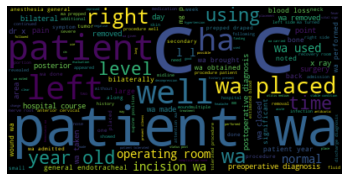

In [18]:
# Transcription for all
from wordcloud import WordCloud
def wordcloud(df):
    wordcloud_ent = WordCloud().generate(' '.join(df['lemmatised_without_stop']))
    plt.imshow(wordcloud_ent, interpolation='bilinear')
    plt.axis("off")
    return plt.show()
wordcloud(df)

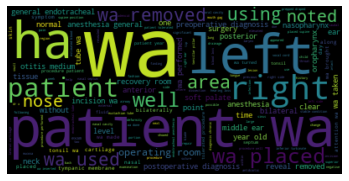

In [19]:
# Transcription for ENT - Otolaryngology
df_ent =df.loc[(df['medical_specialty'] == ' ENT - Otolaryngology')]
wordcloud(df_ent)

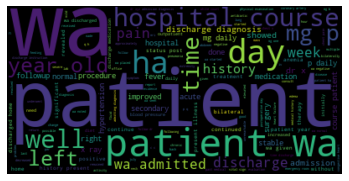

In [20]:
# Transcription for Discharge Summary
df_dc =df.loc[(df['medical_specialty'] == ' Discharge Summary')]
wordcloud(df_dc)

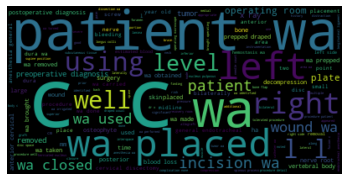

In [21]:
# Transcription for Neurosurgery
df_neu =df.loc[(df['medical_specialty'] == ' Neurosurgery')]
wordcloud(df_neu)

In [22]:
# because the word 'patient' is appeared very often, it is considered as stop words, so remove them
for index, row in df.iterrows():
    row['lemmatised_without_stop'] = row['lemmatised_without_stop'].replace('use', '')
    row['lemmatised_without_stop'] = row['lemmatised_without_stop'].replace('patient', '')
    row['lemmatised_without_stop'] = row['lemmatised_without_stop'].replace('c', '')
    row['lemmatised_without_stop'] = row['lemmatised_without_stop'].replace('wa', '')
    row['lemmatised_without_stop'] = row['lemmatised_without_stop'].replace('ha', '')
    # because remove a word will leave additional place, so code below strip redundant white space
    row['lemmatised_without_stop'] = row['lemmatised_without_stop'].replace('  ', ' ')

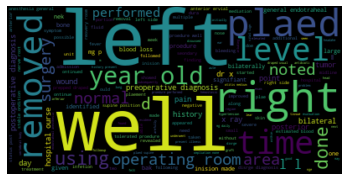

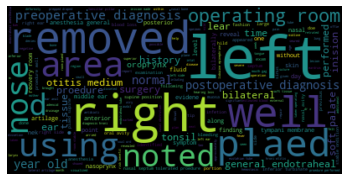

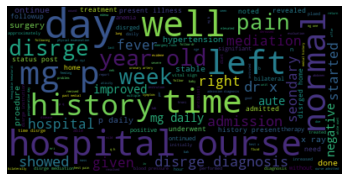

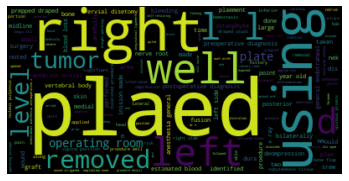

In [23]:
# and then now the word is cleaned, does not has same words that occur many times
df_ent =df.loc[(df['medical_specialty'] == ' ENT - Otolaryngology')]
df_dc =df.loc[(df['medical_specialty'] == ' Discharge Summary')]
df_neu =df.loc[(df['medical_specialty'] == ' Neurosurgery')]
wordcloud(df)
wordcloud(df_ent)
wordcloud(df_dc)
wordcloud(df_neu)

In [24]:
total_word_count_normalised = df['lemmatised_without_stop'].str.split().str.len().sum()
print(f'The word count of transcription after normalised is: {int(total_word_count_normalised)}')
print(f'{round((total_word_count - total_word_count_normalised)/total_word_count*100, 2)}% less word')

The word count of transcription after normalised is: 79575
42.9% less word


In [25]:
total_word_count_normalised_dc = df_dc['lemmatised_without_stop'].str.split().str.len().sum()
print(f'The word count of Discharge Summary transcription after normalised is: {int(total_word_count_normalised_dc)}')
print(f'{round((total_word_count_dc - total_word_count_normalised_dc)/total_word_count_dc*100, 2)}% less word')

The word count of Discharge Summary transcription after normalised is: 25290
41.33% less word


In [26]:
total_word_count_normalised_ent = df_ent['lemmatised_without_stop'].str.split().str.len().sum()
print(f'The word count of ENT transcription after normalised is: {int(total_word_count_normalised_ent)}')
print(f'{round((total_word_count_ent - total_word_count_normalised_ent)/total_word_count_ent*100, 2)}% less word')

The word count of ENT transcription after normalised is: 24242
42.32% less word


In [27]:
total_word_count_normalised_neu = df_neu['lemmatised_without_stop'].str.split().str.len().sum()
print(f'The word count of Neurosrgery transcription after normalised is: {int(total_word_count_normalised_neu)}')
print(f'{round((total_word_count_neu - total_word_count_normalised_neu)/total_word_count_ent*100, 2)}% less word')

The word count of Neurosrgery transcription after normalised is: 30043
57.55% less word


In [28]:
from sklearn import preprocessing
def label_encoding(df, attribute):
    le = preprocessing.LabelEncoder()
    df['encoded_target'] = le.fit_transform(df[attribute])
    return df
df = label_encoding(df, 'medical_specialty')
df.tail(2)

,medical_specialty,lemmatised_without_stop,encoded_target
298,Discharge Summary,final diagnosis herniated nuleus pulposus greater left greater right left radiulopathy moderate stenosis operation anterior ervial disetomy fusion using bengal age slimlok plate intraoperative x ray year old white male offie nek pain left radiulopat...,0
299,Discharge Summary,admitting diagnosis absess ellulitis left foot disrge diagnosis status post left foot proedure inision drainage first metatarsal head left foot ulture sensitivity history present illness presented dr x offie omplaining painful left foot treated onserv...,0


# Features Extraction

We will use sklearn class 'CountVectoriser' to extract different n-grams features. In order to do so, the transcription should be converted into a list format, rather than a dataframe. For the purpose of converting into a flat list (i.e., there is no inner list), the function of 'flat_list' that defined above is used.

In [29]:
def to_list(df, attribute):
    # Select the normalised transcript column 
    df_transcription = df[[attribute]]
    # To convert the attribute into list format, but it has inner list. So it cannot put into the CountVectoriser
    unflat_list_transcription = df_transcription.values.tolist()
    # Let's use back the function defined above, "flat_list", to flatten the list
    flat_list_transcription = flat_list(unflat_list_transcription)
    return flat_list_transcription
flat_list_transcription = to_list(df, 'lemmatised_without_stop')

CountVectorizer is used to convert a collection of transcript documents to a matrix of n-gram features. To explain the ngram_range, all values of n such such that min_n <= n <= max_n will be used. For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams.

In [30]:
n_gram_features ={'unigram':(1,1),'unigram_bigram':(1,2),'bigram':(2,2),\
       'bigram_trigram':(2,3),'trigram':(3,3)}
feature_name=[]
temp=[]
for key, values in n_gram_features.items():
    temp.append(key)
    feature_name.append(key)
temp

['unigram', 'unigram_bigram', 'bigram', 'bigram_trigram', 'trigram']

In [31]:
# Import the CountVectorizer from SkLearn
from sklearn.feature_extraction.text import CountVectorizer
def generate_n_gram_features(flat_list_transcription):
    temp=[]
    for key, values in n_gram_features.items(): 
        vectorizer = CountVectorizer(ngram_range=values)
        vectorizer.fit(flat_list_transcription)
        temp.append(vectorizer.transform(flat_list_transcription))
    return temp
temp = generate_n_gram_features(flat_list_transcription)

In [32]:
for t, f in zip(temp, feature_name):
    print(f'{f}: {t.shape}')

unigram: (298, 7038)
unigram_bigram: (298, 56270)
bigram: (298, 49232)
bigram_trigram: (298, 114215)
trigram: (298, 64983)


After the feature extraction process, 5 kinds of n-gram features are extracted. It is interesting to notice that when the number of 'n' getting higher (i.e, n=1:unigram, n=2:bigram, n=3:trigram), there is a higer number of columns. This is due to it is getting harder to find similar features that can be stored in similar column when it has a longer connected words as one featuer. If the feature is unique, it will automatically append additional column to store the feaure.

# Text Classification

Let's build a simple KNN classifier first. Tree model is imported from sklearn library.

In [33]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
random_state_number =8888

In [34]:
scores =[accuracy_score,f1_score,precision_score,recall_score]
knn = KNeighborsClassifier(weights="distance")
df_target =df[['encoded_target']].values.ravel()

In [35]:
# To build a text classifier
from sklearn.model_selection import cross_val_score
model = knn
def predict_score(temp, df_target, model):
    dictionary ={}
    dictionary['scores'] = ['fl_macro']
    for df, df_name in zip(temp, feature_name):
        X_train, X_test, y_train, y_test = train_test_split(df, df_target, test_size=0.2, random_state=random_state_number)
        result = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
        dictionary[df_name] = result.mean()
    return dictionary

In [36]:
dictionary = predict_score(temp, df_target,knn)
tabulated_results = pd.DataFrame(data=dictionary)
tabulated_results

,scores,unigram,unigram_bigram,bigram,bigram_trigram,trigram
0,fl_macro,0.761412,0.674511,0.352502,0.265268,0.221978


# Experimental - Stemming

In [37]:
# to import SnowballStemmer
from nltk.stem.snowball import SnowballStemmer
def stemming(df, attribute):
    # Use English stemmer.
    stemmer = SnowballStemmer("english")
    df['stemmed'] = df[attribute].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
    return df
df =stemming(df_experiment, 'tokenised')
df.head(2)

,medical_specialty,transcription,tokenised,stemmed
0,Neurosurgery,title of operation a complex closure and debridement of wound indication for surgery the patient is a year old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant just below the costal ma...,"[title, of, operation, a, complex, closure, and, debridement, of, wound, indication, for, surgery, the, patient, is, a, year, old, female, with, a, long, history, of, shunt, and, hydrocephalus, presenting, with, a, draining, wound, in, the, right, upp...","[titl, of, oper, a, complex, closur, and, debrid, of, wound, indic, for, surgeri, the, patient, is, a, year, old, femal, with, a, long, histori, of, shunt, and, hydrocephalus, present, with, a, drain, wound, in, the, right, upper, quadrant, just, belo..."
1,Neurosurgery,title of operation placement of right new ventriculoperitoneal vp shunts strata valve and to removal of right frontal ommaya reservoir indication for surgery the patient is a month old infant born premature with intraventricular hemorrhage and ommaya...,"[title, of, operation, placement, of, right, new, ventriculoperitoneal, vp, shunts, strata, valve, and, to, removal, of, right, frontal, ommaya, reservoir, indication, for, surgery, the, patient, is, a, month, old, infant, born, premature, with, intra...","[titl, of, oper, placement, of, right, new, ventriculoperiton, vp, shunt, strata, valv, and, to, remov, of, right, frontal, ommaya, reservoir, indic, for, surgeri, the, patient, is, a, month, old, infant, born, prematur, with, intraventricular, hemorr..."


In [38]:
# Removing stop words
df['stemmed_without_stop'] = df['stemmed'].apply(lambda x: ' '.join([word for word in x if word not in (stop)]))
df =df.drop(['transcription','stemmed', 'tokenised'], axis=1)
for index, row in df.iterrows():
    row['stemmed_without_stop'] = row['stemmed_without_stop'].replace('use', '')
    row['stemmed_without_stop'] = row['stemmed_without_stop'].replace('patient', '')
    row['stemmed_without_stop'] = row['stemmed_without_stop'].replace('c', '')
    row['stemmed_without_stop'] = row['stemmed_without_stop'].replace('wa', '')
    row['stemmed_without_stop'] = row['stemmed_without_stop'].replace('ha', '')
    # because remove a word will leave additional place, so code below strip redundant white space
    row['stemmed_without_stop'] = row['stemmed_without_stop'].replace('  ', ' ')
df = label_encoding(df, 'medical_specialty')
flat_list_transcription = to_list(df, 'stemmed_without_stop')
temp_stem = generate_n_gram_features(flat_list_transcription)
for t, f in zip(temp_stem, feature_name):
    print(f'{f}: {t.shape}')

unigram: (298, 5507)
unigram_bigram: (298, 53579)
bigram: (298, 48072)
bigram_trigram: (298, 113216)
trigram: (298, 65144)


In [39]:
unigram_lemma = temp[0]
unigram_stem =temp_stem[0]
print(unigram_lemma.shape)
print(unigram_stem.shape)

(298, 7038)
(298, 5507)


In [40]:
# stemmed df
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
param_grid = {'max_depth': [None,30,32,35,37,38,39,40],'min_samples_split': [2,150,170,180,190,200]}
base_estimator = RandomForestClassifier(random_state=random_state_number)
X_train, X_test, y_train, y_test = train_test_split(unigram_stem, df_target, test_size=0.2, random_state=random_state_number)
#X, y = make_classification(n_samples=1000, random_state=0)
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, factor=2, scoring='f1_macro',resource='n_estimators', random_state=random_state_number,
                          max_resources=30).fit(X_train, y_train)
print(sh.best_estimator_)
print(sh.best_score_)

RandomForestClassifier(max_depth=35, n_estimators=16, random_state=8888)
0.8616930877425422


In [41]:
# lemmatised df
from sklearn.ensemble import RandomForestClassifier
param_grid = {'max_depth': [None,30,32,35,37,38,39,40],'min_samples_split': [2,150,170,180,190,200]}
base_estimator = RandomForestClassifier(random_state=random_state_number)
X_train, X_test, y_train, y_test = train_test_split(unigram_lemma, df_target, test_size=0.2, random_state=random_state_number)
#X, y = make_classification(n_samples=1000, random_state=0)
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, factor=2, scoring='f1_macro',resource='n_estimators', random_state=random_state_number,
                          max_resources=30).fit(X_train, y_train)
print(sh.best_estimator_)
print(sh.best_score_)

RandomForestClassifier(max_depth=35, n_estimators=16, random_state=8888)
0.8738667659086058


# Finding best Models

## Finding Optimised Hyperparameter for KNN

In [42]:
import warnings
from sklearn.experimental import enable_halving_search_cv  # noqa
warnings.filterwarnings('ignore')
from sklearn.model_selection import HalvingGridSearchCV
param_grid = {'n_neighbors': [5,7,9,11,13,15,17,19,21]}
base_estimator = KNeighborsClassifier()
X_train, X_test, y_train, y_test = train_test_split(unigram_lemma, df_target, test_size=0.2, random_state=random_state_number)
#X, y = make_classification(n_samples=1000, random_state=0)
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, scoring='f1_macro',random_state=random_state_number,
                          factor=2).fit(X_train, y_train)
print(sh.best_estimator_)
print(sh.best_score_)

KNeighborsClassifier(n_neighbors=7)
0.6363707742380512


## Finding Optimised Hyperparameter for DTC

In [43]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {'max_depth': [None,4,6,7,8,30,32,35],'min_samples_split': [2,3,4,5,35,10,16,20]}
base_estimator = DecisionTreeClassifier(random_state=random_state_number)
X_train, X_test, y_train, y_test = train_test_split(unigram_lemma, df_target, test_size=0.2, random_state=random_state_number)
#X, y = make_classification(n_samples=1000, random_state=0)
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, factor=2, scoring='f1_macro',min_resources="exhaust",random_state=random_state_number,
                          max_resources=30).fit(X_train, y_train)
print(sh.best_estimator_)
print(sh.best_params_)
print(sh.best_score_)

DecisionTreeClassifier(random_state=8888)
{'max_depth': None, 'min_samples_split': 2}
0.6244444444444444


## Finding Optimised Hyperparameter for RFC

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
param_grid = {'max_depth': [None,30,32,35,37,38,39,40],'min_samples_split': [2,150,170,180,190,200]}
base_estimator = RandomForestClassifier(random_state=random_state_number)
X_train, X_test, y_train, y_test = train_test_split(unigram_lemma, df_target, test_size=0.2, \
                                                    random_state=random_state_number)
#X, y = make_classification(n_samples=1000, random_state=0)
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, factor=2, scoring='f1_macro',\
                         resource='n_estimators', random_state=random_state_number,
                          max_resources=30).fit(X_train, y_train)
print(sh.best_estimator_)
print(sh.best_score_)

RandomForestClassifier(max_depth=35, n_estimators=16, random_state=8888)
0.8738667659086058


## Apply the best estimator and tabulate the computed results

## Test Prediction

In [45]:
from sklearn.model_selection import cross_val_score
scores =[accuracy_score,f1_score,precision_score,recall_score]
def predict_score(temp, df_target, model, random):
    dictionary ={}
    dictionary['scores'] = ['accuracy_score','f1_macro','precision_macro','recall_macro']
    for df, df_name in zip(temp, feature_name):
        X_train, X_test, y_train, y_test = train_test_split(df, df_target, test_size=0.2, random_state=random)
        clf = model.fit(X_train, y_train)
        prediction =clf.predict(X_test)
        result_list =[]
        for score in scores:
            if score == accuracy_score:
                result_list.append(score(y_test, prediction))
            else:
                result_list.append(score(y_test, prediction, average='macro'))
        dictionary[df_name] = result_list
    return dictionary, clf

# To know that the model is not overfitting

Test Prediction using default random state

In [46]:
estimator =RandomForestClassifier(max_depth=35, n_estimators=16, random_state=random_state_number)
# default random State =8888
# random State = 8888
dictionary, clf = predict_score(temp, df_target,estimator, 8888)
tabulated_results = pd.DataFrame(data=dictionary)
tabulated_results

,scores,unigram,unigram_bigram,bigram,bigram_trigram,trigram
0,accuracy_score,0.933333,0.850000,0.833333,0.850000,0.583333
1,f1_macro,0.933618,0.852570,0.837207,0.849948,0.577309
2,precision_macro,0.933862,0.859437,0.844591,0.864044,0.705514
3,recall_macro,0.939815,0.865741,0.842593,0.870370,0.606481


In [47]:
def validate_overfitting_default(random):
    dictionary ={}
    X_train, X_test, y_train, y_test = train_test_split(unigram_lemma, df_target, test_size=0.2, random_state=random)
    clf = estimator.fit(X_train, y_train)
    prediction =clf.predict(X_test)
    score = f1_score(y_test, prediction, average='macro')
    print(f'Default test prediction achieve F1-MACRO: {score}')
    return clf
def validate_overfitting(clf, random):
    dictionary ={}
    X_train, X_test, y_train, y_test = train_test_split(unigram_lemma, df_target, test_size=0.3, random_state=random)
    prediction =clf.predict(X_test)
    score = f1_score(y_test, prediction, average='macro')
    print(f'Achieve F1-MACRO: {score} on a train_test split of random state of {random} ')


In [48]:
clf = validate_overfitting_default(8888)
validate_overfitting(clf, 4321)
validate_overfitting(clf, 3131)
validate_overfitting(clf, 1234)
validate_overfitting(clf, 1211)

Default test prediction achieve F1-MACRO: 0.9336182336182336
Achieve F1-MACRO: 0.976975449896884 on a train_test split of random state of 4321 
Achieve F1-MACRO: 0.9887005649717514 on a train_test split of random state of 3131 
Achieve F1-MACRO: 0.9674900263135556 on a train_test split of random state of 1234 
Achieve F1-MACRO: 0.9779480477154895 on a train_test split of random state of 1211 


In [49]:
# random State = 3213
dictionary, clf = predict_score(temp, df_target,estimator, 3213)
tabulated_results = pd.DataFrame(data=dictionary)
tabulated_results

,scores,unigram,unigram_bigram,bigram,bigram_trigram,trigram
0,accuracy_score,0.900000,0.883333,0.783333,0.800000,0.700000
1,f1_macro,0.897727,0.880219,0.754302,0.789076,0.659550
2,precision_macro,0.923611,0.911674,0.801157,0.831034,0.774854
3,recall_macro,0.886710,0.866013,0.754902,0.784880,0.659041


In [50]:
# random State = 6747
dictionary, clf = predict_score(temp, df_target,estimator, 6747)
tabulated_results = pd.DataFrame(data=dictionary)
tabulated_results

,scores,unigram,unigram_bigram,bigram,bigram_trigram,trigram
0,accuracy_score,0.866667,0.850000,0.816667,0.816667,0.683333
1,f1_macro,0.856712,0.835294,0.799522,0.801978,0.651341
2,precision_macro,0.871335,0.844444,0.831481,0.838130,0.751425
3,recall_macro,0.853457,0.835913,0.800826,0.800826,0.650155


In [51]:
# random State = 4321
dictionary, clf = predict_score(temp, df_target,estimator, 4321)
tabulated_results = pd.DataFrame(data=dictionary)
tabulated_results

,scores,unigram,unigram_bigram,bigram,bigram_trigram,trigram
0,accuracy_score,0.883333,0.866667,0.816667,0.900000,0.800000
1,f1_macro,0.862621,0.843849,0.781362,0.883913,0.757191
2,precision_macro,0.875678,0.868056,0.813904,0.900434,0.847495
3,recall_macro,0.854167,0.833333,0.770833,0.875000,0.750000


# To predict each Class

In [52]:
X_train, X_test, y_train, y_test = train_test_split(unigram_lemma, df_target, test_size=0.2, \
                                                    random_state=random_state_number)
clf = estimator.fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
target_names = ['Discharge Summary', 'ENT', 'Neurosurgery']
from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred,target_names=target_names))

                   precision    recall  f1-score   support

Discharge Summary       0.94      0.94      0.94        18
              ENT       1.00      0.88      0.93        24
     Neurosurgery       0.86      1.00      0.92        18

         accuracy                           0.93        60
        macro avg       0.93      0.94      0.93        60
     weighted avg       0.94      0.93      0.93        60

